In [1]:
import h5py
import time
import argparse
import numpy as np
import scipy.io as sio
from copy import deepcopy
from einops import rearrange
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import FactorAnalysis

from auxiliary_classifier import CapsGLOM

from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label

from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch


from Utils import ActivationOutputData
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=24, help='size of patches')
parser.add_argument('--epoches', type=int, default=250, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

In [6]:
def applyFA(X, numComponents=3):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, fa

In [7]:
K = 3
data, fa = applyFA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=3


In [8]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 24
mirror_data shape : [536, 638, 3]
**************************************************
x_train shape = (528, 24, 24, 3), type = float64
x_test  shape = (4683, 24, 24, 3), type = float64
x_true  shape = (5211, 24, 24, 3), type = float64
**************************************************
y_train: shape = (528,), type = int64
y_test: shape = (4683,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [9]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=True)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

torch.Size([528, 3, 24, 24])
torch.Size([4683, 3, 24, 24])
torch.Size([5211, 3, 24, 24])


In [10]:
def WaveletTransformAxisY(batch_img):
    odd_img = batch_img[:, 0::2]  # 奇数行图像 (batch_size, 12, 24)
    even_img = batch_img[:, 1::2]  # 偶数行图像 (batch_size, 12, 24)
    L = (odd_img + even_img) / 2.0  # 奇数行图像加上偶数行图像再除以2 (batch_size, 12, 24)
    H = torch.abs(odd_img - even_img)  # 奇数行图像减去偶数行图像的绝对值 (batch_szie, 12, 24)
    return L, H


def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = rearrange(batch_img, 'b h w -> b w h').flip(2)  # 置换张量中的轴，这一行相当于转置再颠倒首尾
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = rearrange(_dst_L, 'b w h -> b h w').flip(1)
    dst_H = rearrange(_dst_H, 'b w h -> b h w').flip(1)  # 这两步程序中颠倒首尾的操作重复了啊！语法糖
    return dst_L, dst_H

In [11]:
def wavelet(batch_image):
    r = batch_image[:, 0]  # (8, 24, 24)
    g = batch_image[:, 1]  # (8, 24, 24)
    b = batch_image[:, 2]  # (8, 24, 24)

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L) # ((8, 12, 12), (8, 12, 12))
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = torch.stack(wavelet_data, axis=1)  # (8, 12 ,12, 12)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)  # ((8, 6, 12), (8, 6, 12))
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)  # ((8, 6, 6), (8, 6, 6))
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                       g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2, 
                       b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = torch.stack(wavelet_data_l2, axis=1)  # (8, 12, 6, 6)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)  # ((8, 3, 3), (8, 3, 3))

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                       g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3, 
                       b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = torch.stack(wavelet_data_l3, axis=1)  # (8, 12, 3, 3)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                       g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4, 
                       b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = torch.stack(wavelet_data_l4, axis=1)  # (8, 12, 2, 2)

    # (8, 12, 12, 12)  # (8, 12, 6, 6)  # (8, 12, 3, 3)  # (8, 12, 2, 2)
    return [transform_batch, transform_batch_l2, transform_batch_l3, transform_batch_l4]

In [12]:
class Wavelet_CNN(nn.Module):
    def __init__(self, num_classes=13):
        super(Wavelet_CNN, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(12, 64, 3, 2, 7), 
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )  # (batch, 64, 12, 12)
        
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 2, 1), 
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        
        self.conv_a = nn.Sequential(
            nn.Conv2d(12, 64, 3, 1, 1), 
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1), 
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        
        self.conv_b = nn.Sequential(
            nn.Conv2d(12, 64, 3, 1, 1), 
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        
        self.conv_b_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), 
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        
        self.conv_3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        
        self.conv_3_2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 2, 1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        
        self.conv_c = nn.Sequential(
            nn.Conv2d(12, 64, 3, 1, 1), 
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        
        self.conv_c_2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        
        self.conv_c_3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        
        self.conv_4 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        
        self.conv_4_2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 2, 1), 
            nn.BatchNorm2d(256), 
            nn.ReLU()
        )
        
        self.conv_5_1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1), 
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        
        self.pool = nn.AvgPool2d(7, 1, 3)
        
        self.dense = nn.Sequential(
            nn.Linear(128, 2048), 
            nn.ReLU(), 
            nn.Dropout(0.4), 
            nn.Linear(2048, 1024), 
            nn.ReLU(), 
            nn.Dropout(0.4), 
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, input_):
        # x: (batch, 3, 24, 24)
        input_l1, input_l2, input_l3, input_l4 = wavelet(input_)  # ((None, 12, 12, 12), (None, 12, 6, 6), ...)
        relu_1 = self.conv_1(input_l1)  # (None, 64, 12, 12)
        relu_1_2 = self.conv1_2(relu_1)  # (None, 64, 6, 6)
        
        # level 2 decomposition starts
        relu_a = self.conv_a(input_l2)  # (None, 64, 6, 6)
        
        # concate level 1 and level 2 decomposition
        concate_level_2 = torch.concat([relu_1_2, relu_a], axis=1)  # (None, 128, 6, 6)
        relu_2 = self.conv_2(concate_level_2)  # (batch, 128, 6, 6)
        relu_2_2 = self.conv2_2(relu_2)  # (batch, 128, 3, 3)
        
        # level 3 decomposition starts
        relu_b = self.conv_b(input_l3)  # (None, 64, 3, 3)
        relu_b_2 = self.conv_b_2(relu_b)  # (None, 128, 3, 3)
        
        # concate_level 2 and level 3 decomposition
        concate_level_3 = torch.concat([relu_2_2, relu_b_2], axis=1)  # (batch, 256 3, 3)
        relu_3 = self.conv_3(concate_level_3)  # (batch, 256 3, 3)
        relu_3_2 = self.conv_3_2(relu_3)  # (None, 256, 2, 2)
        
        # level 4 decomposition start
        relu_c = self.conv_c(input_l4)  # (None, 2, 2, 64)
        relu_c_2 = self.conv_c_2(relu_c)  # (None, 256, 2, 2)
        
        relu_c_3 =  self.conv_c_3(relu_c_2)  # (None, 256, 2, 2)
        
        # concate level 3 and level 4 decomposition
        concate_level_4 = torch.cat([relu_3_2, relu_c_3], axis=1)  # (None, 512, 2, 2)
        relu_4 = self.conv_4(concate_level_4)  # (None, 256, 2, 2)
        relu_4_2 = self.conv_4_2(relu_4)  # (None, 256, 1, 1)
        
        relu_5_1 = self.conv_5_1(relu_4_2)  # (None, 128, 1, 1)
        
        pool_5_1 = self.pool(relu_5_1)
        
        flatten = pool_5_1.squeeze()
        output = self.dense(flatten)
        return output
        

In [13]:
net = Wavelet_CNN(num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=False)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 15, eta_min=0.0, last_epoch=-1)

In [14]:
tic = time.time()
for epoch in range(args.epoches):
    # train model
    net.train()
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(net, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

Epoch: 001 train_loss: 2.5506 train_acc: 15.3409
Epoch: 002 train_loss: 2.5038 train_acc: 17.6136
Epoch: 003 train_loss: 2.4560 train_acc: 17.6136
Epoch: 004 train_loss: 2.4255 train_acc: 17.6136
Epoch: 005 train_loss: 2.4102 train_acc: 17.6136
Epoch: 006 train_loss: 2.4067 train_acc: 17.6136
Epoch: 007 train_loss: 2.3958 train_acc: 17.6136
Epoch: 008 train_loss: 2.3881 train_acc: 18.1818
Epoch: 009 train_loss: 2.3807 train_acc: 17.6136
Epoch: 010 train_loss: 2.3674 train_acc: 17.6136
Epoch: 011 train_loss: 2.3571 train_acc: 18.1818
Epoch: 012 train_loss: 2.3425 train_acc: 18.3712
Epoch: 013 train_loss: 2.3202 train_acc: 20.8333
Epoch: 014 train_loss: 2.3032 train_acc: 20.8333
Epoch: 015 train_loss: 2.2650 train_acc: 29.7348
Epoch: 016 train_loss: 2.2314 train_acc: 31.4394
Epoch: 017 train_loss: 2.1950 train_acc: 32.1970
Epoch: 018 train_loss: 2.1420 train_acc: 32.1970
Epoch: 019 train_loss: 2.1071 train_acc: 32.1970
Epoch: 020 train_loss: 2.0520 train_acc: 32.1970
Epoch: 021 train_los

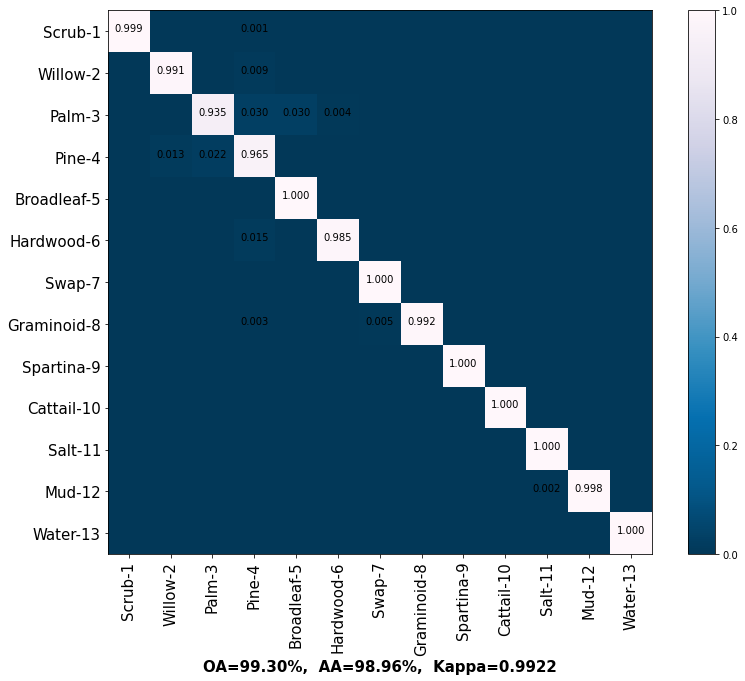

**************************************************
Final result:
OA: 99.30% | AA: 98.96% | Kappa: 0.9922
[0.99853801 0.99082569 0.93478261 0.96460177 1.         0.98543689
 1.         0.99224806 1.         1.         1.         0.99778761
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
gpu_id: 0
seed: 0
batch_size: 32
patch_size: 24
epoches: 250
learning_rate: 0.001
gamma: 0.99
train_number: 1
train_proportion: 0.1
**************************************************


In [16]:
net.eval()
tar_test, pre_test = auxiliary_test_epoch(net, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(net, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_SpectralNET.pdf')

print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")